## Лабораторная работа 3 - Байесовская оптимизация

## Построение регрессии с помощью Гауссовского процесса

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython import display

### Генерация выборки

Ответ на очередном объекте $x_i$ генерируется следующим образом:

$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$

In [3]:
def f(x):
    return -8 * np.sin(x)


support = np.arange(-1.0, 11.0, 1e-2)

In [4]:
X_train = np.arange(0, 10.0, 0.5)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train + 2 * np.random.randn(*X_train.shape)

X_test = support
X_test = X_test.reshape([len(X_test), -1])

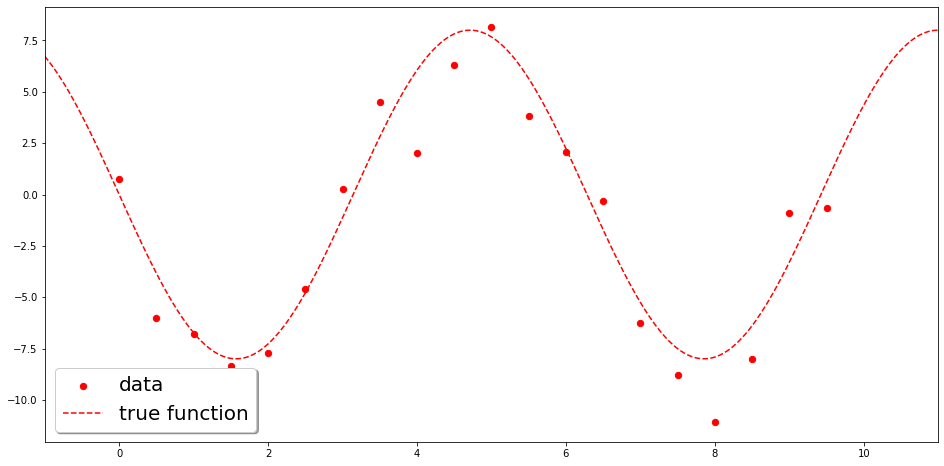

In [5]:
def plot_result(X_train, T_train, support, X_test=None, mu_test=None, sigma_test=None):
    plt.scatter(X_train.flatten(), T_train.flatten(), label="data", c="r", s=40)
    plt.plot(support, f(support), "--r", label="true function")
    if X_test is not None:
        plt.plot(X_test, mu_test, c="b", label="mu test")
        plt.fill_between(
            X_test.flatten(), mu_test - sigma_test, mu_test + sigma_test, color="b", label="confidence", alpha=0.3
        )
    plt.legend(fontsize=20, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support)
plt.show()

### Предсказание

В тестовой точке $x$ мы можем предсказать два параметра – мат. ожидание $\mu(x)$ и стандартное отклонение $\sigma(x)$.
Для заданной ковариационной функции $k(x,y)$ и для заданной дисперсии случайного шума $\beta^{-1}$, $\mu(x), \sigma(x)$ вычисляются по следующим формулам:

$$\mu(x) = \mathbf{k}^TC_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^TC_N^{-1}\mathbf{k},$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Примеры ковариационных функций:
- $K(x,y) = C$ – константная,
- $K(x,y) = \sum_{j=1}^d\theta_jx_jy_j$ – линейная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2)$  – экспоненциальная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j|x_j-y_j|)$ – процесс Орнштейна-Уленбека.

**1.** Реализуте функции вычисления ковариационных матриц между двумя произвольными выборками объектов, а затем функцию, вычисляющую предсказание в новой точке. Циклы использовать запрещено.

In [6]:
def linear_k(X, Y, theta):
    return (X * theta[None, :]).dot(Y.T)

def rbf_k(X, Y, theta):
    dist = (X[:, None, :] - Y[None, :, :]) ** 2
    weighted_dist = (theta[None, None, :] * dist).sum(axis=2)
    return np.exp(-weighted_dist)

def ou_k(X, Y, theta):
    dist = np.abs(X[:, None, :] - Y[None, :, :])
    weighted_dist = (theta[None, None, :] * dist).sum(axis=2)
    return np.exp(-weighted_dist)

def predict(X_train, T_train, X_test, theta, beta, kernel):
    K_T = kernel(X_test, X_train, theta)
    K = K_T.T
    noise_variance = np.zeros((X_train.shape[0], X_train.shape[0]))
    np.fill_diagonal(noise_variance, 1 / beta)
    C = kernel(X_train, X_train, theta) + noise_variance
    C_inv = np.linalg.inv(C)
    mu = K_T.dot(C_inv).dot(T_train)[:, 0]
    noise_variance = np.zeros((X_test.shape[0], X_test.shape[0]))
    np.fill_diagonal(noise_variance, 1 / beta)
    sigma = kernel(X_test, X_test, theta) + noise_variance - K_T.dot(C_inv).dot(K)
    return mu, np.sqrt(sigma.diagonal())

### Экспоненциальная ковариационная функция

In [7]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

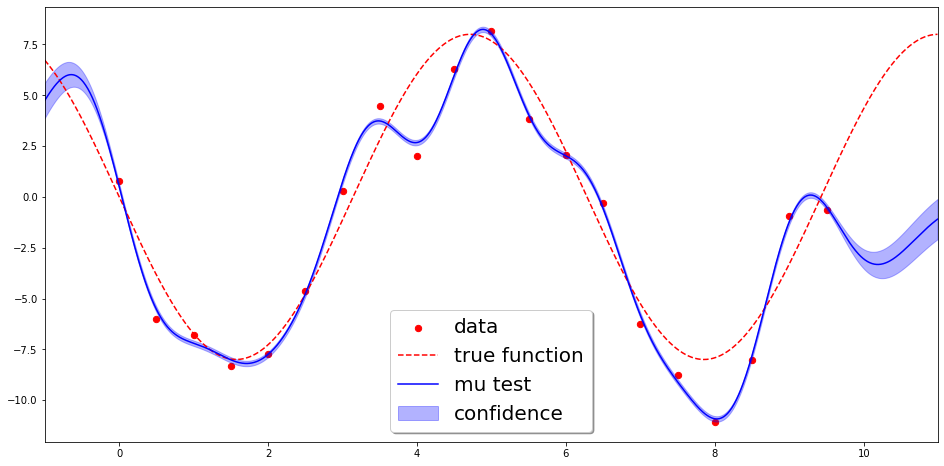

In [8]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

Посмотрим как ведёт себя регрессия для разных значений $\beta$

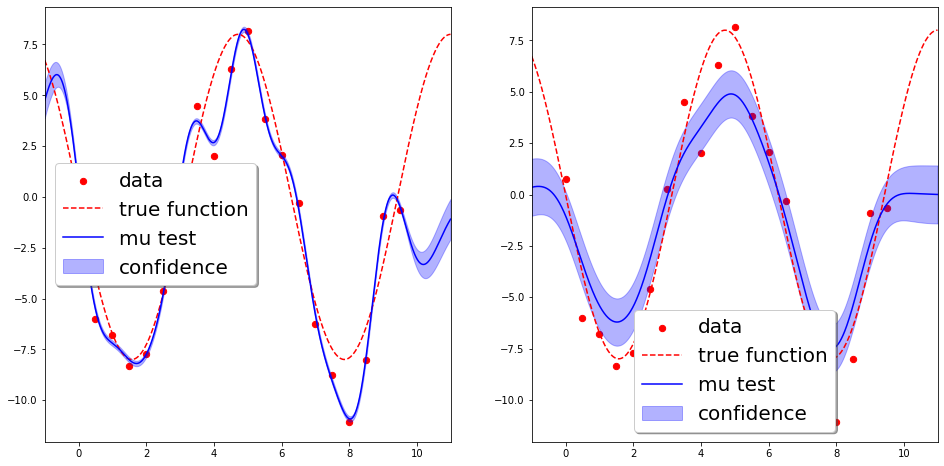

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.subplot(122)
theta = np.array([1.0])
beta = 1.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

Запишите что вы пронаблюдали и как можно интерпретировать параметр $\beta$.

Параметр $\beta$ позволяет регулировать сложность модели: более высокое значение сильнее адаптируется к данным и уменьшает "разброс" уверенности.
Однако это приводит к явному переобучению модели.

### Линейная ковариационная функция

In [10]:
theta = np.array([1.0])
beta = 100.0
kernel = linear_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

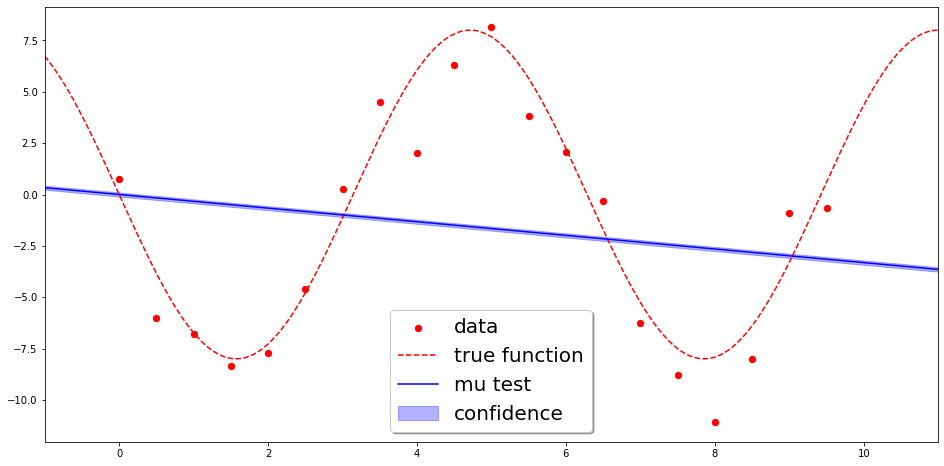

In [11]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

### Ковариационная функция Орнштейна-Уленбека

In [12]:
theta = np.array([1.0])
beta = 100.0
kernel = ou_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

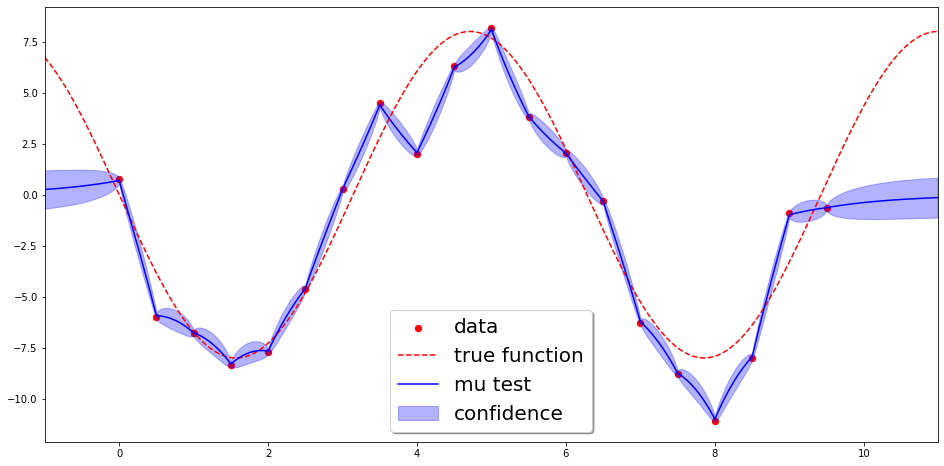

In [13]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

На практике часто прибегают к смеси ковариационных функций, чтобы добиться определённых свойств регрессии.

In [14]:
theta = np.array([1.0])
beta = 10.0
kernel = lambda X, Y, theta: ou_k(X, Y, theta) + rbf_k(X, Y, theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

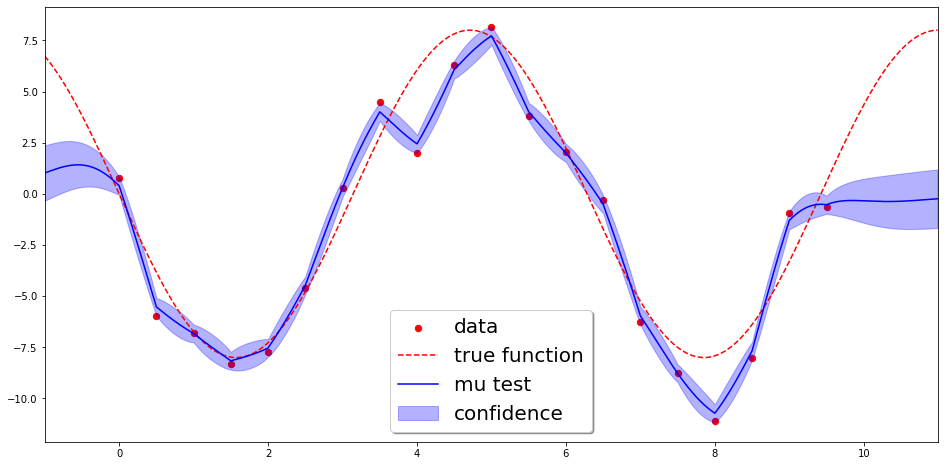

In [15]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

### Подбор параметров

Подбор параметров $\theta$ для произвольного ядра можно сделать максимизируя логарифм правдоподобия на обучающей выборке:

$$\log p(\mathbf{t}|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}\mathbf{t}^TC_N^{-1}\mathbf{t} - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$$

Максимизировать заданный функционал мы будем с помощью градиентного подъёма. Однако, мы будем проводить оптимизацию по $\log\theta$ (т.е. считать градиенты относительно $\log\theta$ и обновлять $\log\theta$, а не сами $\theta$), поскольку так процесс проще сходится

Вам пригодится формула для градиента по $\theta$:

$$\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}\mathbf{t}$$

**2.** 

  а) Получите формулу для расчёта градиента логарифма правдоподобия по $\log\theta$ 

  б) Реализуйте функцию для расчёта градиента логарифма правдоподобия по $\log\theta$ а также функцию для расчёта правдоподобия. Ядро – RBF.

In [16]:
def get_rbf_grad_log_theta(X, Y, theta, beta):
    C = np.zeros((X.shape[0], X.shape[0]))
    np.fill_diagonal(C, 1 / beta)
    K = rbf_k(X, X, theta)
    C += K
    grad_C = -K[None, :, :] * (X.T[:, None, :] - X.T[:, :, None]) ** 2 # shape = (d, N, N)
    C_inv = np.linalg.inv(C)
    grad_C_dot_C_inv = grad_C.dot(C_inv) # shape = (d, N, N)
    fi_summand = grad_C_dot_C_inv.diagonal(axis1=1, axis2=2).sum(axis=1)
    se_summand = Y.T.dot(C_inv).dot((grad_C_dot_C_inv.dot(Y)[:, :, 0]).T)[0]
    return (se_summand - fi_summand) / 2

def get_log_likelihood(X, Y, theta, beta):
    C = np.zeros((X.shape[0], X.shape[0]))
    np.fill_diagonal(C, 1 / beta)
    C += rbf_k(X, X, theta)
    C_inv = np.linalg.inv(C)
    log_likelihood = -np.log(np.linalg.det(C)) / 2
    log_likelihood -= Y.T.dot(C_inv).dot(Y) / 2
    log_likelihood -= X.shape[0] / 2 * np.log(2 * np.pi)
    return log_likelihood

In [17]:
lr = 1e-3
num_iterations = 100
beta = 100.0
log_theta = np.log(np.array([10.0]))
log_likelihood = np.zeros(num_iterations)
theta_history = np.zeros(num_iterations)
for i in range(num_iterations):
    theta_history[i] = np.exp(log_theta)
    log_theta = log_theta + lr * get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
    log_likelihood[i] = get_log_likelihood(X_train, T_train, np.exp(log_theta), beta)

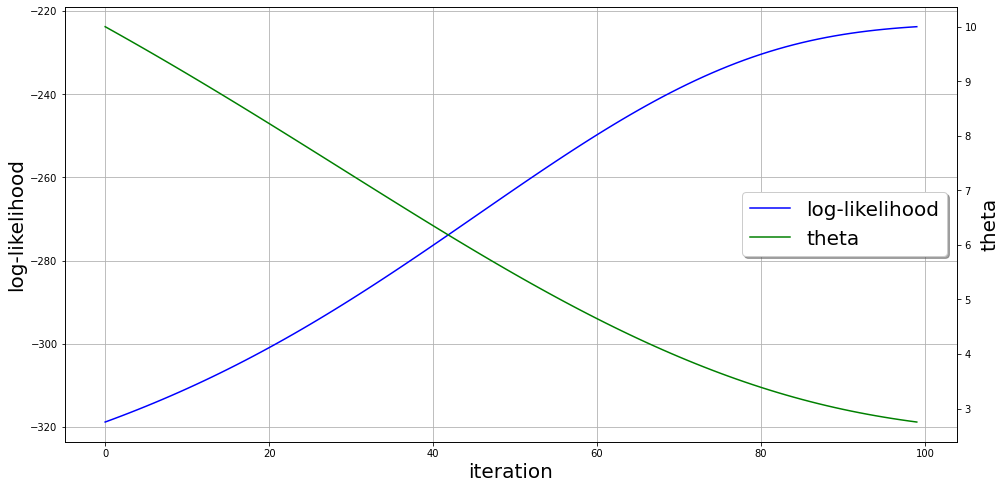

In [18]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

ax1.plot(log_likelihood, label="log-likelihood", c="b")
ax1.set_xlabel("iteration", fontsize=20)
ax1.set_ylabel("log-likelihood", fontsize=20)
ax1.grid()

ax2.plot(theta_history, label="theta", c="g")
ax2.set_ylabel("theta", fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, fontsize=20, loc="center right", frameon=True, shadow=True)
plt.show()

In [19]:
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)

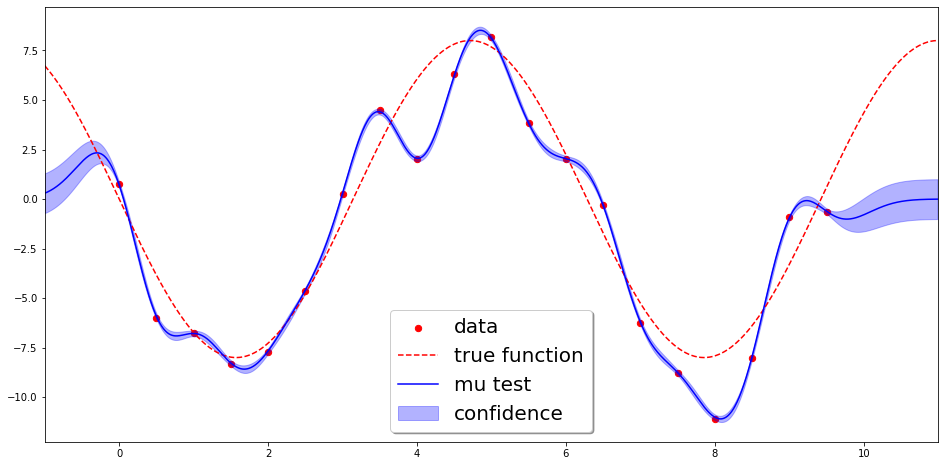

In [20]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support, X_test, mu_test, sigma_test)
plt.show()

Сравните этот график с графиком для $\theta=1$. Что произошло с мат. ожиданием? Как изменился параметр $\theta$?  
(_пункт не оценивается_)

## Оптимизация с помощью Гауссовского процесса

С помощью Гауссовского процесса можно решать задачи black-box оптимизации. То есть, оптимизировать функцию, вид которой нам не известен и нет никакой дополнительной информации, кроме её значений в некоторых точках. Такой метод оптимизации может использоваться для поиска экстремумов некоторой функции, которую очень дорого вычислять, а градиенты этой функции мы и вовсе не можем рассчитать.

Концепция такого алгоритма оптимизации следующая:
1. Настраиваем параметры Гауссовского процесса для имеющегося набора точек.
2. В каждой точке пространства $x$ мы можем посчитать величину expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)),$$
где $t_{\min}$ – минимальное значение целевой переменной на уже имеющейся выборке.  
На практике же, мы не можем посчитать expected improvement в каждой точке пространства, но мы можем оптимизировать эту функцию относительно $x$ методами первого или второго порядка и найти локальный максимум этой функции.
3. В качестве новой точки выбираем $x^* = \text{argmax}\; \text{EI}(x)$ и рассчитываем значение $t^*$ в этой точке. После чего добавляем эту точку к нашим данным и возвращаемся к шагу 1.

Сгенерируем выборку

In [21]:
def f(x):
    return -1 / np.sqrt(2 * np.pi * 0.25) * np.exp(-0.5 / 0.09 * (x - 4) ** 2) - 1 / np.sqrt(2 * np.pi * 1.0) * np.exp(
        -0.5 / 1.0 * (x - 8) ** 2
    )


support = np.arange(0.95, 11.1, 1e-2)

In [22]:
X_train = np.arange(2.0, 10.0, 3.0)
X_train = X_train + (2.0 * np.random.rand(len(X_train)) - 1.0)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train

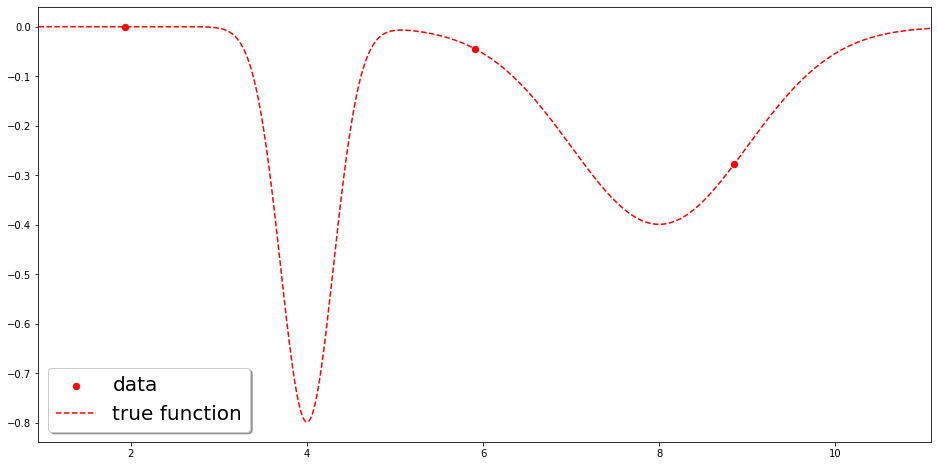

In [23]:
plt.figure(figsize=(16, 8))
plot_result(X_train, T_train, support)
plt.show()

**3.** Выведите формулу для expected improvement.

_Приведите свои рассуждения здесь_

**4.** Реализуйте функцию для расчёта expected improvement.

In [24]:
def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
    y_min = np.min(T_train)
    cdf_centered_normalized = stats.norm.cdf((y_min - mu_test) / sigma_test)
    res = (y_min - mu_test) * cdf_centered_normalized
    res += sigma_test / np.sqrt(2 * np.pi) * (np.exp(-(y_min - mu_test) ** 2 / (2 * sigma_test ** 2)))
    return res

In [25]:
X_test = support
X_test = X_test.reshape([len(X_test), -1])

In [26]:
def plot_expected_improvement(X_train, T_train, expected_improvement, predictions, sigma):
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
    ax2 = ax1.twinx()

    ax1.scatter(X_train.flatten(), T_train.flatten(), label="data", c="r", s=40)
    ax1.plot(support, predictions, label="mean")
    ax1.fill_between(support, predictions - sigma, predictions + sigma, color="b", alpha=0.3, label="uncertainty")
    ax1.plot(support, f(support), "--r", label="true function")
    ax1.grid()

    ax2.plot(support, expected_improvement, label="Expected improvement", c="g")
    ax2.scatter(support[np.argmax(expected_improvement)], np.max(expected_improvement), label="max", c="g", s=40)
    ax2.set_ylabel("Expected improvement", fontsize=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, fontsize=10, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

Запустите процесс оптимизации. Сошёлся ли он в точку минимума? Попробуйте разные значения параметров.  
(_пункт не оценивается_)

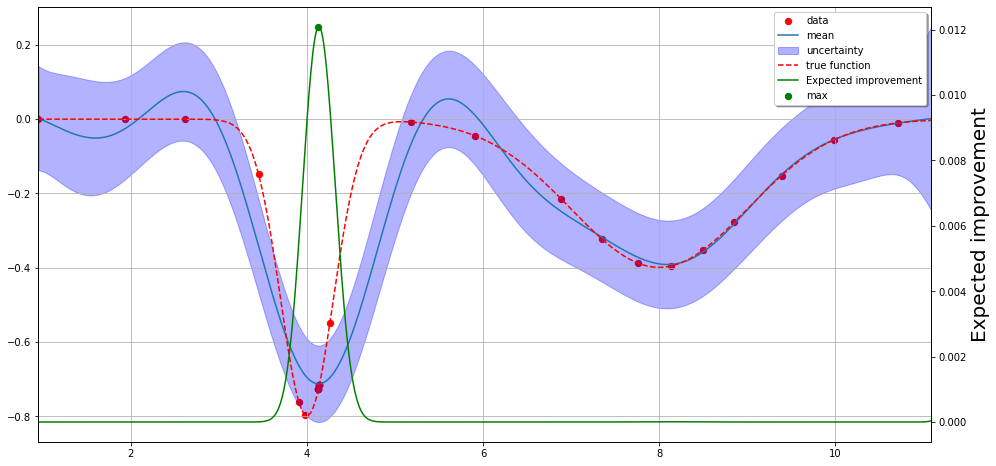

<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [27]:
beta = 100.0
num_tuning_steps = 500
num_new_points = 30
lr = 1e-2
for _ in range(num_new_points):
    plt.clf()
    # model tuning
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
        log_theta = log_theta + lr * grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    mu, sigma = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    plot_expected_improvement(X_train, T_train, expected_improvement, mu, sigma)
    # adding new point
    X_train = np.vstack([X_train, np.array(support[np.argmax(expected_improvement)])])
    T_train = f(X_train)

    display.clear_output(wait=True)
    display.display(plt.gcf())

_ = plt.clf()